# Урок 4. Построение алгоритма дерева решений

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import pandas as pd

Неопределенность Джини (Gini impurity): $$G = \sum\limits_k p_k(1 - p_k)^2$$

 ### ООП реализация

In [2]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction_classification = self.predict()
        self.prediction_regression = self.predict_reg()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

    def predict_reg(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction  

In [4]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [5]:
# Расчет качества для задачи классификации
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [6]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [7]:
# Нахождение наилучшего разбиения для задачи классификации
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [8]:
# Построение дерева классификации с помощью рекурсивной функции
def build_tree_classification(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [9]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_classification
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [10]:
def predict_class(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

## Проверим работоспособность дерева классификации


In [11]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=2020)

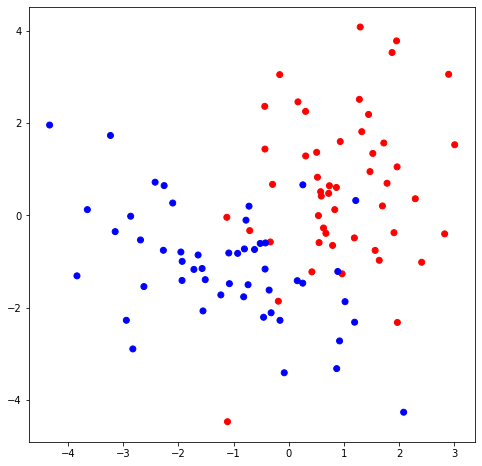

In [12]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[3], classification_data)), list(map(lambda x: x[0], classification_data)), 
              c=classification_labels, cmap=colors);

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [14]:
custom_tree = build_tree_classification(train_data, train_labels, max_depth=3)

In [15]:
custom_tree

In [16]:
y_train_pred = predict_class(train_data, custom_tree)
y_test_pred = predict_class(test_data, custom_tree)

In [17]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
print(accuracy_metric(train_labels, y_train_pred))
print(accuracy_metric(test_labels, y_test_pred))

97.14285714285714
90.0


In [19]:
# Напечатаем ход нашего дерева
def print_tree_classification(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction_classification)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_classification(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree_classification(node.false_branch, spacing + "  ")
    
print_tree_classification(custom_tree)

Индекс 2
Порог -0.3552924905936442
--> True:
  Прогноз: 1
--> False:
  Индекс 4
  Порог 0.1711577568472622
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 1


### Домашнее задание. 

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  

In [20]:
# Нахождение наилучшего разбиения для задачи классификации (min_leaf argument added)
def find_best_split_hmw(data, labels,min_leaf):
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [21]:
# Построение дерева классификации с помощью рекурсивной функции (min_leaf argument added)
def build_tree_classification_hmw(data, labels, tree_depth=1, max_depth=50,min_leaf=5):

    quality, t, index = find_best_split_hmw(data, labels,min_leaf)
    print('mid',index)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification_hmw(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification_hmw(false_data, false_labels, tree_depth, max_depth)
    print('last',index)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [22]:
def classify_object_hmw(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_classification
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [23]:
def predict_class_hmw(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [24]:
def accuracy_metric_hmw(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [25]:
hmw_tree_50_5 = build_tree_classification_hmw(train_data, train_labels, max_depth=5,min_leaf=2)

mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2


In [26]:
bran = hmw_tree_50_5.false_branch

In [27]:
bran

In [28]:
#y_train_pred_1 = predict_class_hmw(train_data, hmw_tree_50_5)
y_test_pred_1 = predict_class_hmw(test_data, hmw_tree_50_5)

In [29]:
#rint(accuracy_metric_hmw(train_labels, y_train_pred_1))
print(accuracy_metric_hmw(test_labels, y_test_pred_1))

90.0


In [30]:
def choose_best_params(train_data, train_labels):
    max_depth=1
    min_leaf=1
    leaf =0
    depth =0
    test =0
    for n in range(100):
        for m in range(50):
            hmw_tree = build_tree_classification_hmw(train_data, train_labels, max_depth=n+1, min_leaf=m+1)
            y_test_pred = predict_class_hmw(test_data, hmw_tree)
            accuracy_test = accuracy_metric_hmw(test_labels, y_test_pred)
            m +=2
            if test < accuracy_test:
                test = accuracy_test
                leaf = n+1
                depth = m
        n +=1
#        print(leaf, depth, test)
    return leaf, depth, test

In [31]:
best_params = choose_best_params(train_data, train_labels)

mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid None
mid 4
last 2
mid 2
mid N

mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid N

mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mi

mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid N

last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid N

mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mi

mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid N

mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid N

mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mi

mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mi

mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mi

mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mi

mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None


mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
la

mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None


mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid 

mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mi

mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
m

mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 

mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
l

mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mi

mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None


mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mi

mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid No

mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mi

mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mi

mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mi

mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mi

mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
last 2
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None
mid None


mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 3
mid None
mid None
last 3
mid 4
mid None
mid None
last 4
las

mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
las

mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 0
mid None
mid None
last 0
last 2
mid 2
mid 2
mid N

mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid None
mid 4
mid 0
mid None
mid None
last 0
mid None
last 4
last 2
mid 2
mid 2
mid None
mid None
last 2
mid 1
mid 0
mid None
mid None
last 0
mid None
last 1
last 2
mid 2
mid

In [32]:
best_params

(3, 2, 90.0)

In [33]:
hmw_tree_bestparams = build_tree_classification_hmw(train_data, train_labels, max_depth=3,min_leaf=2)

mid 2
mid None
mid 4
mid 0
mid None
last 4
last 2


In [34]:
y_train_pred_2 = predict_class_hmw(train_data, hmw_tree_bestparams)
y_test_pred_2 = predict_class_hmw(test_data, hmw_tree_bestparams)

In [35]:
print(accuracy_metric_hmw(train_labels, y_train_pred_2))
print(accuracy_metric_hmw(test_labels, y_test_pred_2))

97.14285714285714
90.0


In [36]:
data_test = pd.DataFrame(classification_data)

In [37]:
data_test.head(10)

,0,1,2,3,4
0,1.365354,-1.946831,0.587621,0.504151,0.910715
1,-0.043623,-2.474552,1.868962,-1.123818,-1.819347
2,-0.390821,-2.315886,0.786749,0.671679,-0.424529
3,1.567044,-0.576358,0.786094,1.720740,-0.350715
4,-0.534469,1.923938,-0.882704,-2.688124,0.179217
5,2.185490,-1.634067,1.137512,1.444533,-0.644837
6,-0.376596,1.298557,0.576912,1.905155,-3.228558
7,-0.402620,-0.108856,-0.312375,2.823388,-0.754553
8,0.670853,-1.203032,2.264650,-0.295241,-2.581829
9,0.825537,-2.261650,1.253570,0.518395,-0.168836



2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [184]:
# Расчёт дисперсии значений (вместо gini)
def dispersion(target):
    return np.std(target)


# Расчет качества для задачи регрессии
def quality_regression(left_target, right_target, current_dispersion):
    
    p = len(left_target)/(len(left_target)+len(right_target))
    
    return current_dispersion - p * dispersion(left_target) - (1 - p) * dispersion(right_target)


# аналог classify_object для регрессии
def predict_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction_regression
        return answer
     
    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

    
# аналог predict_class для регрессии
def predict_value(data, tree):
    val = []
    for obj in data:
        prediction = predict_object(obj, tree)
        val.append(prediction)
 
    return val
    

# Нахождение наилучшего разбиения для задачи регрессии
def find_best_split_regression(data, target):
     
        #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_dispersion = dispersion(target)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            left_data, right_data, left_target, right_target = split(data, target, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(left_data) < min_leaf or len(right_data) < min_leaf:
                continue
            
            current_quality = quality_regression(left_target, right_target, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
   

    return best_quality, best_t, best_index


# Построение дерева регрессии с помощью рекурсивной функции
def build_tree_regression(data, target, tree_depth=1, max_depth=10):

    
    quality, t, index = find_best_split_regression(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, target)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, target)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    left_data, right_data, left_target, right_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    left_branch = build_tree_regression(left_data, left_target, tree_depth, max_depth)
    right_branch = build_tree_regression(right_data, right_target, tree_depth, max_depth)
    

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, left_branch, right_branch)


In [185]:
# сгенерируем данные
reg_data, reg_target = datasets.make_regression(n_features = 5, n_informative = 5, 
                                                      n_targets=1, random_state=2020)

In [186]:
from sklearn import model_selection

train_data, test_data, train_target, test_target = model_selection.train_test_split(reg_data, reg_target, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 42)

In [187]:
regression_tree = build_tree_regression(train_data, train_target)

In [188]:
train_y_predict = predict_value(train_data, regression_tree)

In [189]:
test_y_predict = predict_value(test_data, regression_tree)

In [190]:
#r2 metric
def calc_r2(y, y_pred):
    d = np.sum((y - np.mean(y))**2)
    d_er = np.sum((y - y_pred)**2)
    return 1-(d_er/d)

In [191]:
print(calc_r2(train_target, train_y_predict), calc_r2(test_target, test_y_predict))

0.9999610438483452 0.5485745651150266
